In [67]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import re   # regular expression -> düzenli ifadeler ile metin işleme
import os
from PIL import Image
import numpy as np
import csv
import pandas as pd
from scipy.spatial import procrustes
from sklearn.neighbors import NearestNeighbors

In [47]:
# dosya adındaki sayılara göre sıralama yapmak için
def sort_key_func(file_path):
    # dosya adındaki sayıları çıkart ve integer'a çevir
    numbers = re.findall(r'\d+', file_path)
    return int(numbers[0]) if numbers else 0

In [48]:
# görüntülerin bulunduğu yol"
images_path = r"C:\Users\sevva\OneDrive\Masaüstü\yzup-bitirme\frames\*.jpg"

sorted_images_files = sorted(glob(images_path), key=sort_key_func)

# SIFT kullanımmı
sift = cv2.SIFT_create() # en iyi ilk 500 özellik icin nfeatures = 500
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# önceki noktaları tutmak için
prev_keypoints = None
prev_descriptors = None
prev_image = None

trajectory = []  # Konum verilerini saklamak için

In [49]:
for idx, image_path in enumerate(sorted_images_files):
    
    # görüntü yükleme ve işleme 
    pil_image = Image.open(image_path)
    open_cv_image = np.array(pil_image)[:, :, ::-1]  # PIL'den OpenCV formatına çevir
    gray_image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY) # openCV BGR formatını kullandıgı icin bgr to gray
    
    # özellik tespiti ve eslestirme 
    keypoints, descriptors = sift.detectAndCompute(gray_image, None) 

    if prev_descriptors is not None:
        matches = bf.match(prev_descriptors, descriptors)
        matches = sorted(matches, key=lambda x: x.distance)

        matched_image = cv2.drawMatches(prev_image, prev_keypoints, 
                                        gray_image, keypoints, matches[:50], 
                                        None, 
                                        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
        # Hareket vektörünü hesapla ve yörüngeyi güncelle

        # İki ardışık görüntü arasında bulunan eşleşmelerin listesini döngü içine alıyoruz
        motion_vectors = []  # Her bir eşleşme için hareket vektörlerini tutacak liste

        for match in matches:
            # Eşleşme bilgisinden eğitim görüntüsündeki özellik noktasının konumunu alıyoruz
            current_keypoint = keypoints[match.trainIdx].pt  # Mevcut görüntüdeki özellik noktası
            previous_keypoint = prev_keypoints[match.queryIdx].pt  # Önceki görüntüdeki özellik noktası

            # Numpy dizilerine dönüştürüyoruz ki aritmetik işlem yapabilmek için
            current_position = np.array(current_keypoint)
            previous_position = np.array(previous_keypoint)

            # İki özellik noktası arasındaki farkı hesaplıyoruz, bu bir vektör oluşturur
            displacement_vector = current_position - previous_position

            # Hesaplanan vektörü listeye ekliyoruz
            motion_vectors.append(displacement_vector)

        # Tüm hareket vektörlerinin ortalamasını alarak genel bir hareket vektörü hesaplıyoruz
        # Bu, ortalama bir taşınımı (translasyonu) ifade eder
        motion_vector = np.mean(motion_vectors, axis=0)

        if len(trajectory) > 0:
            current_position = trajectory[-1] + motion_vector
        else:
            current_position = motion_vector
        trajectory.append(current_position)

        if idx % 100 == 0:  # Her 100 görüntüde bir görselleştir
            plt.figure(figsize=(12, 8))
            plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
            plt.title(f"Feature Matching: Image {idx}")
            plt.axis('off')
            plt.show()
            
    # Bu görüntüyü bir sonraki iterasyon için sakla
    prev_keypoints = keypoints
    prev_descriptors = descriptors
    prev_image = gray_image

KeyboardInterrupt: 

In [ ]:
# Yörünge verilerini CSV dosyasına kaydet

# w -> yazma modu, newline='' -> satır sonu gereksiz bosluk yok
with open('trajectory_01.csv', 'w', newline='') as file: 
    writer = csv.writer(file)
    writer.writerow(['x_position', 'y_position'])
    writer.writerows(trajectory)

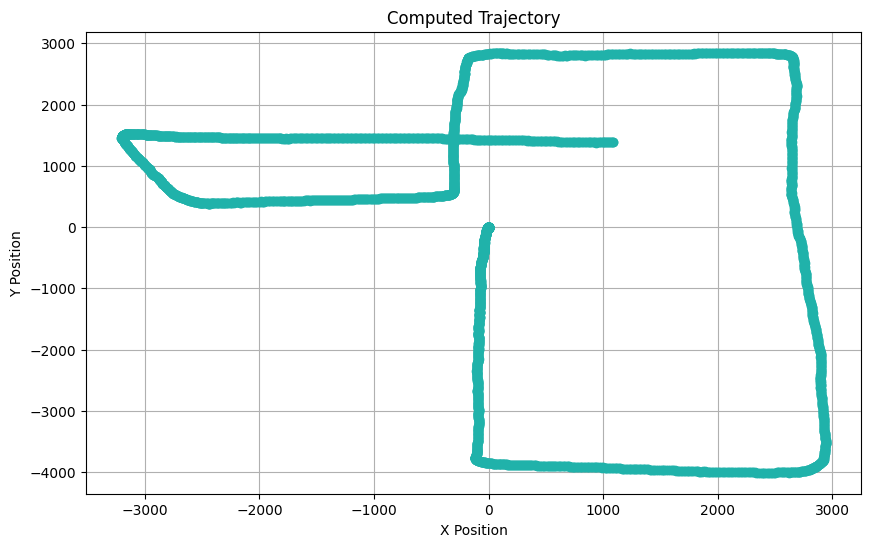

In [ ]:
# CSV dosyasını yükle
data_vo = pd.read_csv(r'C:\Users\sevva\OneDrive\Masaüstü\yzup-bitirme\trajectory_01.csv')

plt.figure(figsize=(10, 6))
plt.plot(-data_vo['x_position'], -data_vo['y_position'], 
         marker='o', linestyle='-', color='lightseagreen', label='Trajectory')
plt.title('Computed Trajectory')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.show()

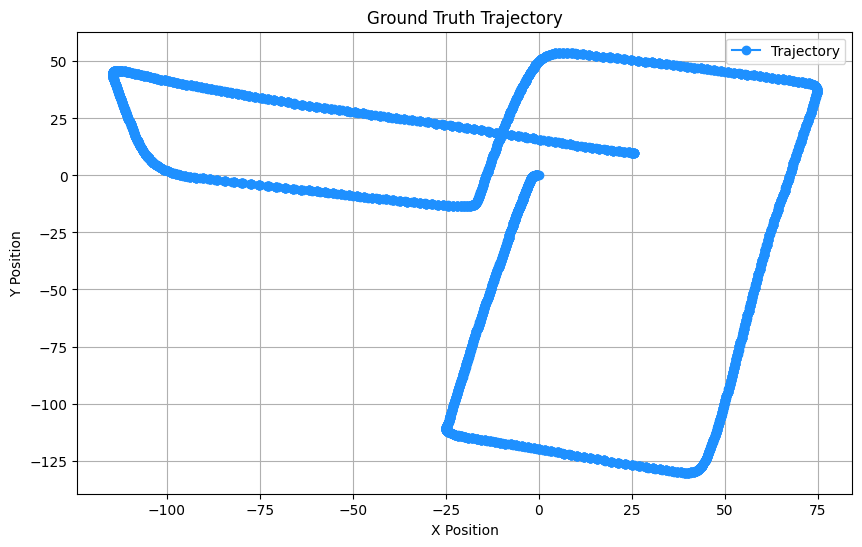

In [ ]:
# CSV dosyasını yükle
data_gt = pd.read_csv(r'C:\Users\sevva\OneDrive\Masaüstü\yzup-bitirme\GT_Translations.csv')

# x ve y pozisyonlarını çiz
plt.figure(figsize=(10, 6))
plt.plot(data_gt['translation_x'], data_gt['translation_y'], 
         marker='o', linestyle='-', color='dodgerblue', label='Trajectory')
plt.title('Ground Truth Trajectory')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# CSV dosyasındaki sütun adlarını kontrol edin
data_gt = pd.read_csv('GT_Translations.csv')
print(data_gt.columns)

y_gt = data_gt['translation_y'][1:]
print(y_gt)

x_vo = data_vo['x_position']
y_vo = data_vo['y_position']
frame = np.arange(len(x_vo))
print(len(y_vo))


x_gt = data_gt['translation_x'][1:]
y_gt = data_gt['translation_y'][1:]
frame = np.arange(len(x_gt))
print(len(y_gt))



Index(['translation_x', 'translation_y', 'frame_numbers'], dtype='object')
1       0.007047
2       0.008401
3       0.008401
4       0.008401
5       0.008401
          ...   
3317    9.769882
3318    9.769882
3319    9.769882
3320    9.769882
3321    9.769882
Name: translation_y, Length: 3321, dtype: float64
3321
3321


x_vo: 3321
y_vo: 3321
x_gt: 3321
y_gt: 3321
error_x: 3321
error_y: 3321


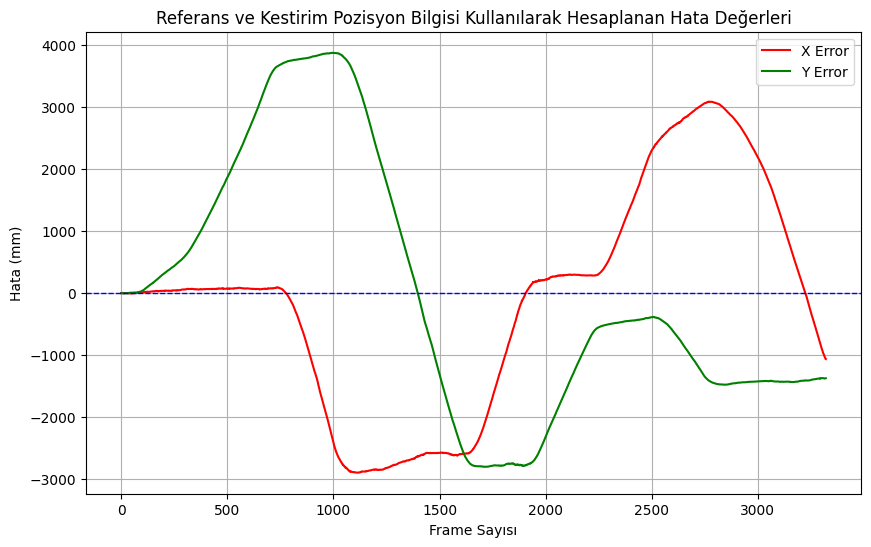

In [ ]:
# VO ve GT verilerini yükleyin
data_vo = pd.read_csv('trajectory.csv')
data_gt = pd.read_csv('GT_Translations.csv')

# Frame number ve pozisyon sütunlarını alın
x_vo = -data_vo['x_position']
y_vo = -data_vo['y_position']

# Ground truth verilerini yükleyin
x_gt = data_gt['translation_x'][1:]
y_gt = data_gt['translation_y'][1:]

# Uzunlukları kontrol edin
print(f"x_vo: {len(x_vo)}")
print(f"y_vo: {len(y_vo)}")
print(f"x_gt: {len(x_gt)}")
print(f"y_gt: {len(y_gt)}")

# Hataları hesaplayın
error_x = x_gt.values - x_vo.values
error_y = y_gt.values - y_vo.values

# Hata boyutlarını kontrol edin
print(f"error_x: {len(error_x)}")
print(f"error_y: {len(error_y)}")

# Hata grafiği çizimi
plt.figure(figsize=(10, 6))
# X ekseni hatalarını çizin
plt.plot(frame, error_x, label='X Error', color='red')
# Y ekseni hatalarını çizin
plt.plot(frame, error_y, label='Y Error', color='green')
# Y=0 referans çizgisi çiz
plt.axhline(0, color='blue', linewidth=1, linestyle='--')

# Grafiği düzenleyin
plt.xlabel('Frame Sayısı')
plt.ylabel('Hata (mm)')
plt.title('Referans ve Kestirim Pozisyon Bilgisi Kullanılarak Hesaplanan Hata Değerleri')
plt.legend()
plt.grid(True)

# Grafiği gösterin
plt.show()

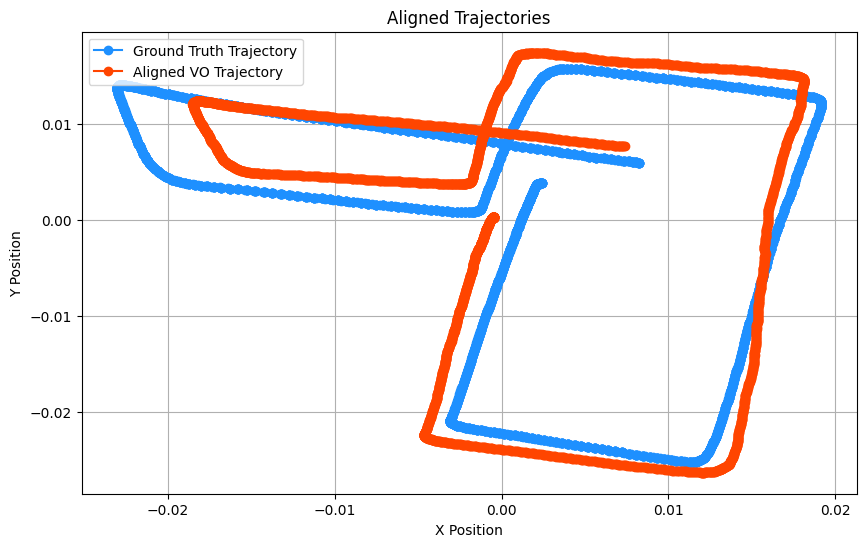

In [65]:
# procrustes
# VO ve GT verilerini yükle
data_vo = pd.read_csv(r'C:\Users\sevva\OneDrive\Masaüstü\yzup-bitirme\trajectory_01.csv')
data_gt = pd.read_csv(r'C:\Users\sevva\OneDrive\Masaüstü\yzup-bitirme\GT_Translations.csv')

# Verileri numpy array olarak dönüştür
vo_coordinates = np.column_stack((data_vo['x_position'], data_vo['y_position']))  # Negatif işaret kullanımı
gt_coordinates = np.column_stack((data_gt['translation_x'][1:], data_gt['translation_y'][1:]))

# Procrustes analizi ile hizalama (scipy'daki Procrustes metodu ölçek değişikliği yapmaz)
mtx1, mtx2, disparity = procrustes(gt_coordinates, vo_coordinates)

# Hizalanmış VO verilerini çiz
plt.figure(figsize=(10, 6))
plt.plot(mtx1[:, 0], mtx1[:, 1], marker='o', linestyle='-', color='dodgerblue', label='Ground Truth Trajectory')
plt.plot(mtx2[:, 0], mtx2[:, 1], marker='o', linestyle='-', color='orangered', label='Aligned VO Trajectory')
plt.title('Aligned Trajectories')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Hataları X ve Y için ayrı ayrı hesapla
error_x = mtx1[:, 0] - mtx2[:, 0]
error_y = mtx1[:, 1] - mtx2[:, 1]

# X ve Y hataları için istatistiksel değerleri hesapla ve yazdır
for coord, errors in zip(['X', 'Y'], [error_x, error_y]):
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    max_error = np.max(errors)
    min_error = np.min(errors)

    print(f"{coord} Hatası - Ortalama: {mean_error:.4f}, Standart Sapma: {std_error:.4f}, Maksimum: {max_error:.4f}, Minimum: {min_error:.4f}")
    print(f"{coord} Hatası - MSE: {mse:.4f}, RMSE: {rmse:.4f}\n")



X Hatası - Ortalama: -0.0000, Standart Sapma: 0.0022, Maksimum: 0.0029, Minimum: -0.0048
X Hatası - MSE: 0.0000, RMSE: 0.0022

Y Hatası - Ortalama: 0.0000, Standart Sapma: 0.0019, Maksimum: 0.0036, Minimum: -0.0035
Y Hatası - MSE: 0.0000, RMSE: 0.0019



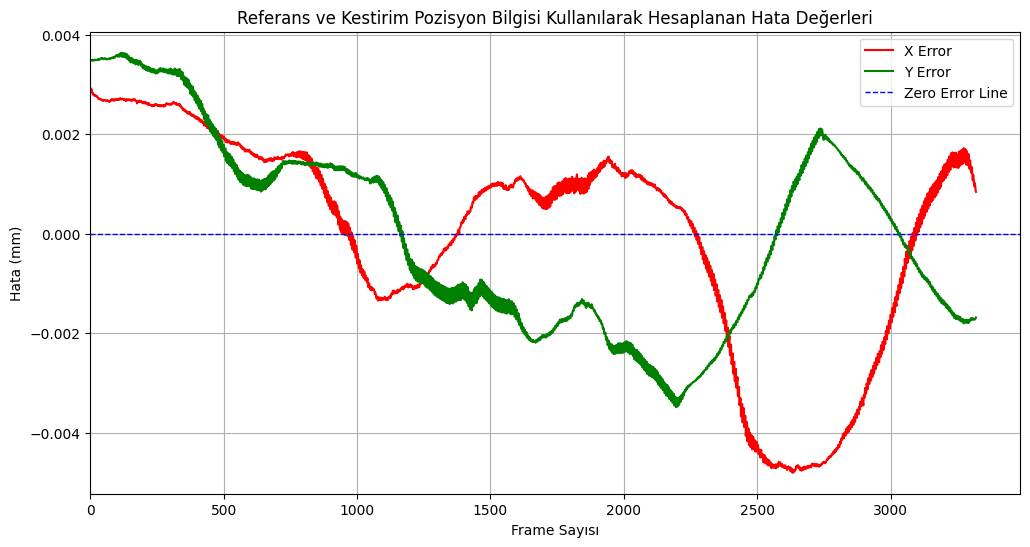

In [ ]:
# Hata değerlerini çiz
plt.figure(figsize=(12, 6))
plt.plot(frame, error_x, label='X Error', color='red', linestyle='-', markersize=5)
plt.plot(frame, error_y, label='Y Error', color='green', linestyle='-', markersize=5)
plt.axhline(0, color='blue', linestyle='--', label='Zero Error Line', linewidth=1)  # Sıfır hatası çizgisi

# Y-ekseni sınırlarını ayarla
plt.xlim(left=0)  # X-ekseni sınırlarını ayarla

plt.title('Referans ve Kestirim Pozisyon Bilgisi Kullanılarak Hesaplanan Hata Değerleri')
plt.xlabel('Frame Sayısı')
plt.ylabel('Hata (mm)')
plt.legend()
plt.grid(True)
plt.show()

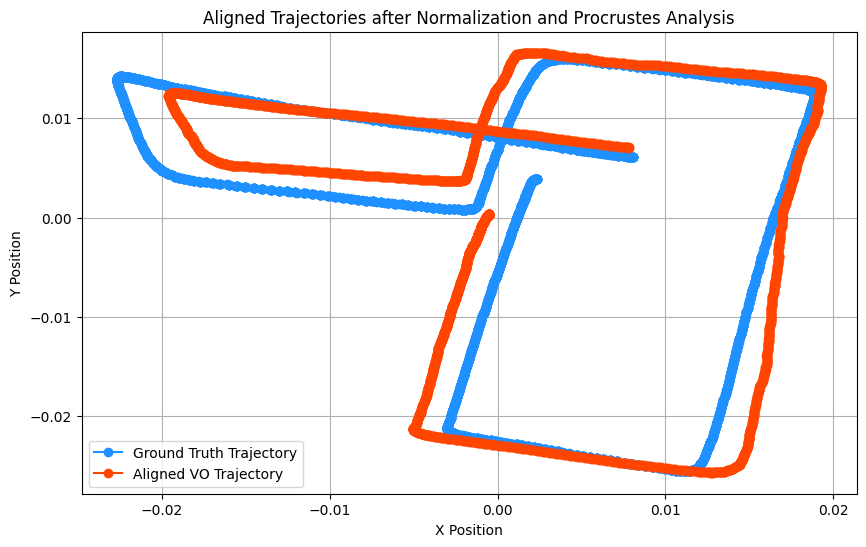

In [66]:
# Verileri yükle
data_vo = pd.read_csv('trajectory_01.csv')
data_gt = pd.read_csv('GT_Translations.csv')

# Verileri numpy array olarak dönüştür
vo_coordinates = np.column_stack((-data_vo['x_position'], -data_vo['y_position']))
gt_coordinates = np.column_stack((data_gt['translation_x'][1:], data_gt['translation_y'][1:]))

# Normalizasyon işlemi
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

vo_coordinates_normalized = np.column_stack((normalize(vo_coordinates[:, 0]), normalize(vo_coordinates[:, 1])))
gt_coordinates_normalized = np.column_stack((normalize(gt_coordinates[:, 0]), normalize(gt_coordinates[:, 1])))

# Procrustes analizi ile hizalama (scipy'daki Procrustes metodu ölçek değişikliği yapmaz)
mtx1, mtx2, disparity = procrustes(gt_coordinates_normalized, vo_coordinates_normalized)

# Hizalanmış VO verilerini çiz
plt.figure(figsize=(10, 6))
plt.plot(mtx1[:, 0], mtx1[:, 1], marker='o', linestyle='-', color='dodgerblue', label='Ground Truth Trajectory')
plt.plot(mtx2[:, 0], mtx2[:, 1], marker='o', linestyle='-', color='orangered', label='Aligned VO Trajectory')
plt.title('Aligned Trajectories after Normalization and Procrustes Analysis')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()


X Hatası - Ortalama: 0.0000, Standart Sapma: 0.0019, Maksimum: 0.0029, Minimum: -0.0034
X Hatası - MSE: 0.0000, RMSE: 0.0019

Y Hatası - Ortalama: -0.0000, Standart Sapma: 0.0016, Maksimum: 0.0036, Minimum: -0.0033
Y Hatası - MSE: 0.0000, RMSE: 0.0016



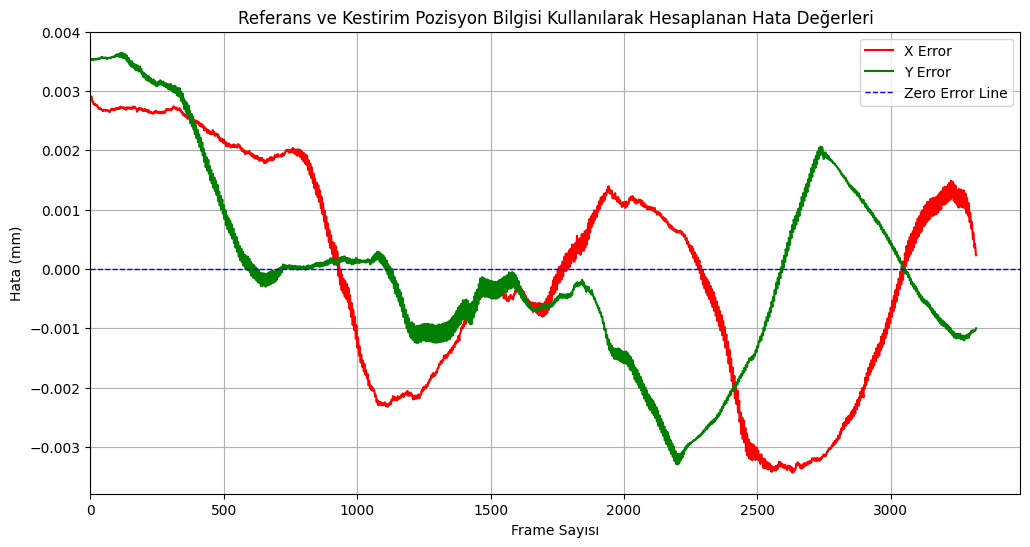

In [59]:
# Hataları X ve Y için ayrı ayrı hesapla
error_x = mtx1[:, 0] - mtx2[:, 0]
error_y = mtx1[:, 1] - mtx2[:, 1]

# X ve Y hataları için istatistiksel değerleri hesapla ve yazdır
for coord, errors in zip(['X', 'Y'], [error_x, error_y]):
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    max_error = np.max(errors)
    min_error = np.min(errors)

    print(f"{coord} Hatası - Ortalama: {mean_error:.4f}, Standart Sapma: {std_error:.4f}, Maksimum: {max_error:.4f}, Minimum: {min_error:.4f}")
    print(f"{coord} Hatası - MSE: {mse:.4f}, RMSE: {rmse:.4f}\n")

# Hata değerlerini çiz
plt.figure(figsize=(12, 6))
frame = np.arange(len(error_x))  # Frame sayısını oluştur
plt.plot(frame, error_x, label='X Error', color='red', linestyle='-', markersize=5)
plt.plot(frame, error_y, label='Y Error', color='green', linestyle='-', markersize=5)
plt.axhline(0, color='blue', linestyle='--', label='Zero Error Line', linewidth=1)  # Sıfır hatası çizgisi

# Y-ekseni sınırlarını ayarla
plt.xlim(left=0)  # X-ekseni sınırlarını ayarla

plt.title('Referans ve Kestirim Pozisyon Bilgisi Kullanılarak Hesaplanan Hata Değerleri')
plt.xlabel('Frame Sayısı')
plt.ylabel('Hata (mm)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors

# ICP fonksiyonu
def icp(A, B, max_iterations=100, tolerance=1e-10):
    # En yakın komşu bulma
    def nearest_neighbor(src, dst):
        from sklearn.neighbors import NearestNeighbors
        neigh = NearestNeighbors(n_neighbors=1)
        neigh.fit(dst)
        distances, indices = neigh.kneighbors(src, return_distance=True)
        return distances.ravel(), indices.ravel()

    # Dönüşüm matrisini hesapla
    def best_fit_transform(A, B):
        assert A.shape == B.shape
        m = A.shape[0]
        centroid_A = np.mean(A, axis=0)
        centroid_B = np.mean(B, axis=0)
        AA = A - centroid_A
        BB = B - centroid_B
        H = np.dot(AA.T, BB)
        U, S, Vt = np.linalg.svd(H)
        R = np.dot(Vt.T, U.T)
        if np.linalg.det(R) < 0:
            Vt[m-1, :] *= -1
            R = np.dot(Vt.T, U.T)
        t = centroid_B.T - np.dot(R, centroid_A.T)
        return R, t

    src = np.copy(A)
    prev_error = 0

    for i in range(max_iterations):
        distances, indices = nearest_neighbor(src, B)
        R, t = best_fit_transform(src, B[indices])
        src = np.dot(src, R.T) + t
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    T = np.identity(3)
    T[:2, :2] = R
    T[:2, 2] = t

    return T, distances

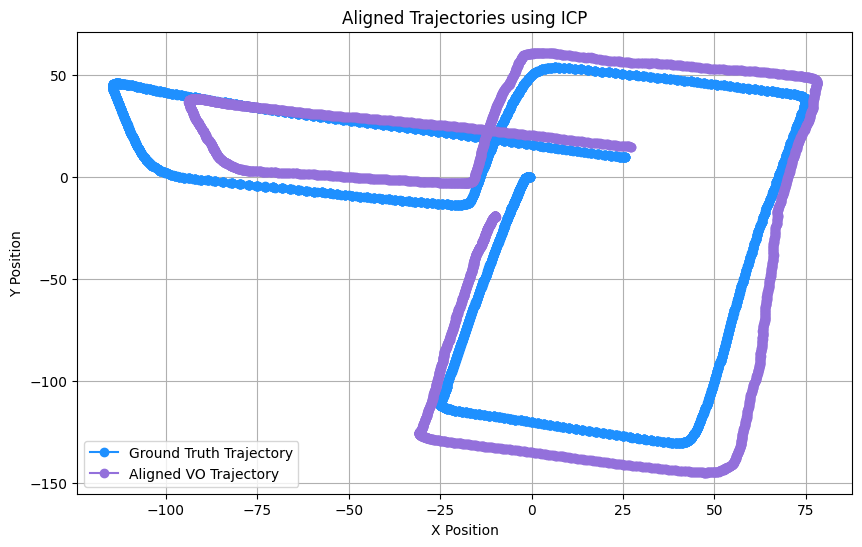

In [50]:
# VO ve GT verilerini yükleyin
data_vo = pd.read_csv('trajectory_01.csv')
data_gt = pd.read_csv('GT_Translations.csv')

# Verileri numpy array olarak dönüştür
vo_coordinates = np.column_stack((-data_vo['x_position'], 
                                  -data_vo['y_position']))
gt_coordinates = np.column_stack((data_gt['translation_x'][1:], 
                                  data_gt['translation_y'][1:]))

# Ölçek faktörünü hesaplayın
vo_length = np.sum(np.sqrt(np.sum(np.diff(vo_coordinates, axis=0)**2, axis=1)))
gt_length = np.sum(np.sqrt(np.sum(np.diff(gt_coordinates, axis=0)**2, axis=1)))
scale_factor = gt_length / vo_length

# VO verilerini ölçeklendirin
vo_coordinates *= scale_factor

# ICP hizalamasını gerçekleştirin
T, distances = icp(vo_coordinates, gt_coordinates)

# Dönüştürülmüş VO koordinatlarını hesaplayın
aligned_vo_coordinates = np.dot(T[:2, :2], vo_coordinates.T).T + T[:2, 2]

# Hizalanmış VO verilerini çiz
plt.figure(figsize=(10, 6))
plt.plot(gt_coordinates[:, 0], gt_coordinates[:, 1], 
         marker='o', linestyle='-', color='dodgerblue', 
         label='Ground Truth Trajectory')
plt.plot(aligned_vo_coordinates[:, 0], aligned_vo_coordinates[:, 1], 
         marker='o', linestyle='-', color='mediumpurple', 
         label='Aligned VO Trajectory')
plt.title('Aligned Trajectories using ICP')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

X Hatası - Ortalama: -3.4871, Standart Sapma: 9.0477, Maksimum: 9.6895, Minimum: -22.0582
X Hatası - MSE: 94.0210, RMSE: 9.6964

Y Hatası - Ortalama: 3.5281, Standart Sapma: 10.0951, Maksimum: 19.8606, Minimum: -13.2804
Y Hatası - MSE: 114.3588, RMSE: 10.6939



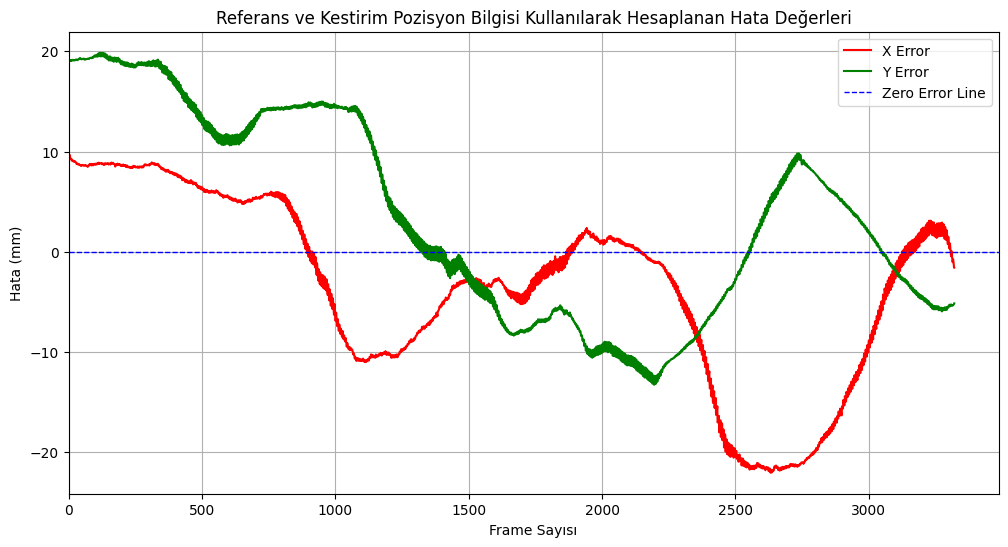

In [51]:
# Hataları X ve Y için ayrı ayrı hesapla
error_x = gt_coordinates[:, 0] - aligned_vo_coordinates[:, 0]
error_y = gt_coordinates[:, 1] - aligned_vo_coordinates[:, 1]

# X ve Y hataları için istatistiksel değerleri hesapla ve yazdır
for coord, errors in zip(['X', 'Y'], [error_x, error_y]):
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    max_error = np.max(errors)
    min_error = np.min(errors)

    print(f"{coord} Hatası - Ortalama: {mean_error:.4f}, Standart Sapma: {std_error:.4f}, 
          Maksimum: {max_error:.4f}, Minimum: {min_error:.4f}")
    print(f"{coord} Hatası - MSE: {mse:.4f}, RMSE: {rmse:.4f}\n")

# Hata değerlerini çiz
plt.figure(figsize=(12, 6))
frame = np.arange(len(error_x))  # Frame sayısını oluştur
plt.plot(frame, error_x, label='X Error', color='red', linestyle='-', markersize=5)
plt.plot(frame, error_y, label='Y Error', color='green', linestyle='-', markersize=5)
plt.axhline(0, color='blue', linestyle='--', label='Zero Error Line', linewidth=1)  # Sıfır hatası çizgisi

# Y-ekseni sınırlarını ayarla
plt.xlim(left=0)  # X-ekseni sınırlarını ayarla

plt.title('Referans ve Kestirim Pozisyon Bilgisi Kullanılarak Hesaplanan Hata Değerleri')
plt.xlabel('Frame Sayısı')
plt.ylabel('Hata (mm)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Normalizasyon işlemi
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# ICP hizalama fonksiyonu
def best_fit_transform(A, B):
    assert A.shape == B.shape

    # Orta noktayı hesapla
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    # Merkezden uzaklaşma
    AA = A - centroid_A
    BB = B - centroid_B

    # Kovaryans matrisi hesapla
    H = np.dot(AA.T, BB)

    # SVD kullanarak döndürme matrisi hesapla
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # Yansıma olmasını önlemek için son SVD'den sonra işareti düzelt
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # Kaydırma vektörü hesapla
    t = centroid_B.T - np.dot(R, centroid_A.T)

    # Transform matrisi oluştur
    T = np.identity(A.shape[1] + 1)
    T[:A.shape[1], :A.shape[1]] = R
    T[:A.shape[1], A.shape[1]] = t

    return T

def icp(A, B, max_iterations=20, tolerance=1e-5):
    src = np.ones((A.shape[0], A.shape[1] + 1))
    dst = np.ones((B.shape[0], B.shape[1] + 1))
    src[:, :-1] = A
    dst[:, :-1] = B

    prev_error = 0

    for i in range(max_iterations):
        # En yakın komşuları bul
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(dst[:, :-1])
        distances, indices = nbrs.kneighbors(src[:, :-1])

        # Dönüşüm matrisini hesapla
        T = best_fit_transform(src[:, :-1], dst[indices[:, 0], :-1])

        # Kaynak noktalarını dönüştür
        src = np.dot(T, src.T).T

        # Hata hesapla
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    T = best_fit_transform(A, src[:, :-1])
    return T, distances

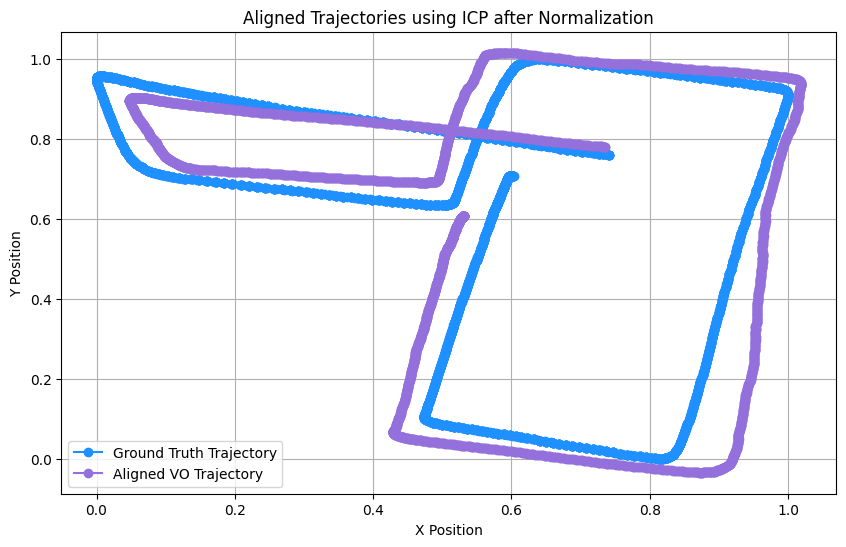

In [57]:
# Verileri yükle
data_vo = pd.read_csv('trajectory_01.csv')
data_gt = pd.read_csv('GT_Translations.csv')

# Verileri numpy array olarak dönüştür
vo_coordinates = np.column_stack((-data_vo['x_position'], -data_vo['y_position']))
gt_coordinates = np.column_stack((data_gt['translation_x'][1:], data_gt['translation_y'][1:]))

vo_coordinates_normalized = np.column_stack((normalize(vo_coordinates[:, 0]), normalize(vo_coordinates[:, 1])))
gt_coordinates_normalized = np.column_stack((normalize(gt_coordinates[:, 0]), normalize(gt_coordinates[:, 1])))

# ICP hizalamasını gerçekleştir
T, distances = icp(vo_coordinates_normalized, gt_coordinates_normalized)

# Dönüştürülmüş VO koordinatlarını hesaplayın
aligned_vo_coordinates = np.dot(T[:2, :2], vo_coordinates_normalized.T).T + T[:2, 2]

# Hizalanmış VO verilerini çiz
plt.figure(figsize=(10, 6))
plt.plot(gt_coordinates_normalized[:, 0], gt_coordinates_normalized[:, 1], marker='o', linestyle='-', color='dodgerblue', label='Ground Truth Trajectory')
plt.plot(aligned_vo_coordinates[:, 0], aligned_vo_coordinates[:, 1], marker='o', linestyle='-', color='mediumpurple', label='Aligned VO Trajectory')
plt.title('Aligned Trajectories using ICP after Normalization')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

X Hatası - Ortalama: 0.0026, Standart Sapma: 0.0448, Maksimum: 0.0733, Minimum: -0.0782
X Hatası - MSE: 0.0020, RMSE: 0.0449

Y Hatası - Ortalama: 0.0148, Standart Sapma: 0.0436, Maksimum: 0.1030, Minimum: -0.0683
Y Hatası - MSE: 0.0021, RMSE: 0.0460



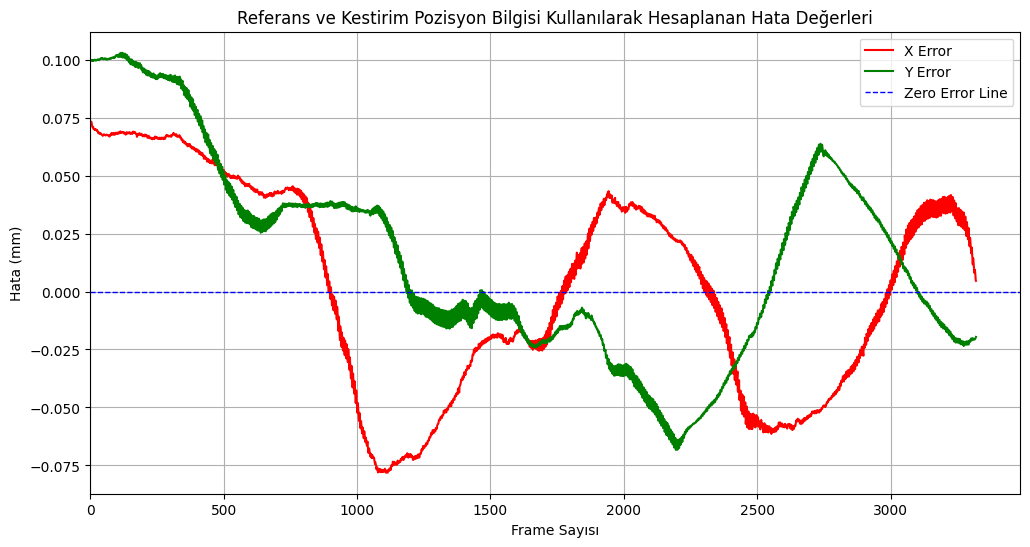

In [60]:
# Hataları X ve Y için ayrı ayrı hesapla
error_x = gt_coordinates_normalized[:, 0] - aligned_vo_coordinates[:, 0]
error_y = gt_coordinates_normalized[:, 1] - aligned_vo_coordinates[:, 1]

# X ve Y hataları için istatistiksel değerleri hesapla ve yazdır
for coord, errors in zip(['X', 'Y'], [error_x, error_y]):
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    max_error = np.max(errors)
    min_error = np.min(errors)

    print(f"{coord} Hatası - Ortalama: {mean_error:.4f}, Standart Sapma: {std_error:.4f}, Maksimum: {max_error:.4f}, Minimum: {min_error:.4f}")
    print(f"{coord} Hatası - MSE: {mse:.4f}, RMSE: {rmse:.4f}\n")

# Hata değerlerini çiz
plt.figure(figsize=(12, 6))
frame = np.arange(len(error_x))  # Frame sayısını oluştur
plt.plot(frame, error_x, label='X Error', color='red', linestyle='-', markersize=5)
plt.plot(frame, error_y, label='Y Error', color='green', linestyle='-', markersize=5)
plt.axhline(0, color='blue', linestyle='--', label='Zero Error Line', linewidth=1)  # Sıfır hatası çizgisi

# Y-ekseni sınırlarını ayarla
plt.xlim(left=0)  # X-ekseni sınırlarını ayarla

plt.title('Referans ve Kestirim Pozisyon Bilgisi Kullanılarak Hesaplanan Hata Değerleri')
plt.xlabel('Frame Sayısı')
plt.ylabel('Hata (mm)')
plt.legend()
plt.grid(True)
plt.show()

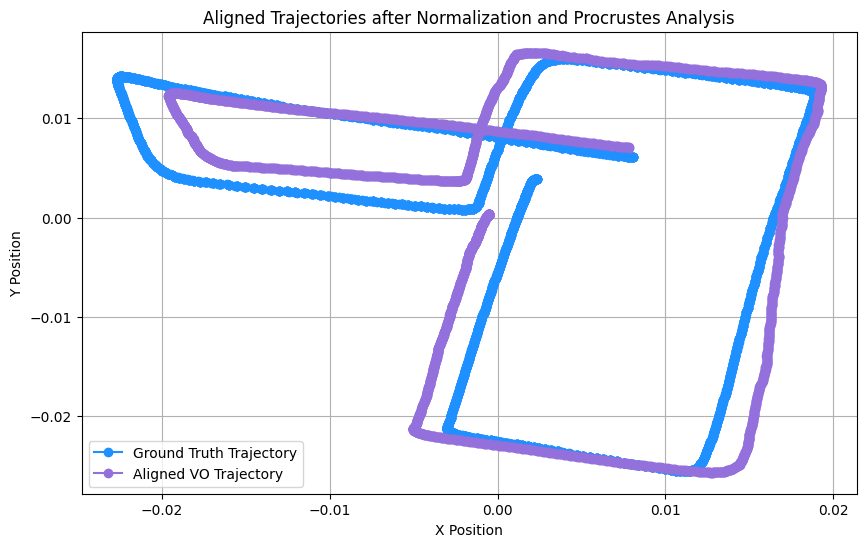

In [32]:
# Normalizasyon + procrustes

data_vo = pd.read_csv('trajectory_01.csv')
data_gt = pd.read_csv('GT_Translations.csv')

# Verileri numpy array olarak dönüştür
vo_coordinates = np.column_stack((data_vo['x_position'], data_vo['y_position']))
gt_coordinates = np.column_stack((data_gt['translation_x'][1:], data_gt['translation_y'][1:]))

# Normalizasyon işlemi
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

vo_coordinates_normalized = np.column_stack((normalize(vo_coordinates[:, 0]), normalize(vo_coordinates[:, 1])))
gt_coordinates_normalized = np.column_stack((normalize(gt_coordinates[:, 0]), normalize(gt_coordinates[:, 1])))

# Procrustes analizi ile hizalama (scipy'daki Procrustes metodu ölçek değişikliği yapmaz)
mtx1, mtx2, disparity = procrustes(gt_coordinates_normalized, vo_coordinates_normalized)

# Hizalanmış VO verilerini çiz
plt.figure(figsize=(10, 6))
plt.plot(mtx1[:, 0], mtx1[:, 1], marker='o', linestyle='-', color='dodgerblue', label='Ground Truth Trajectory')
plt.plot(mtx2[:, 0], mtx2[:, 1], marker='o', linestyle='-', color='mediumpurple', label='Aligned VO Trajectory')
plt.title('Aligned Trajectories after Normalization and Procrustes Analysis')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()


X Hatası - Ortalama: 0.0000, Standart Sapma: 0.0019, Maksimum: 0.0029, Minimum: -0.0034
X Hatası - MSE: 0.0000, RMSE: 0.0019

Y Hatası - Ortalama: -0.0000, Standart Sapma: 0.0016, Maksimum: 0.0036, Minimum: -0.0033
Y Hatası - MSE: 0.0000, RMSE: 0.0016



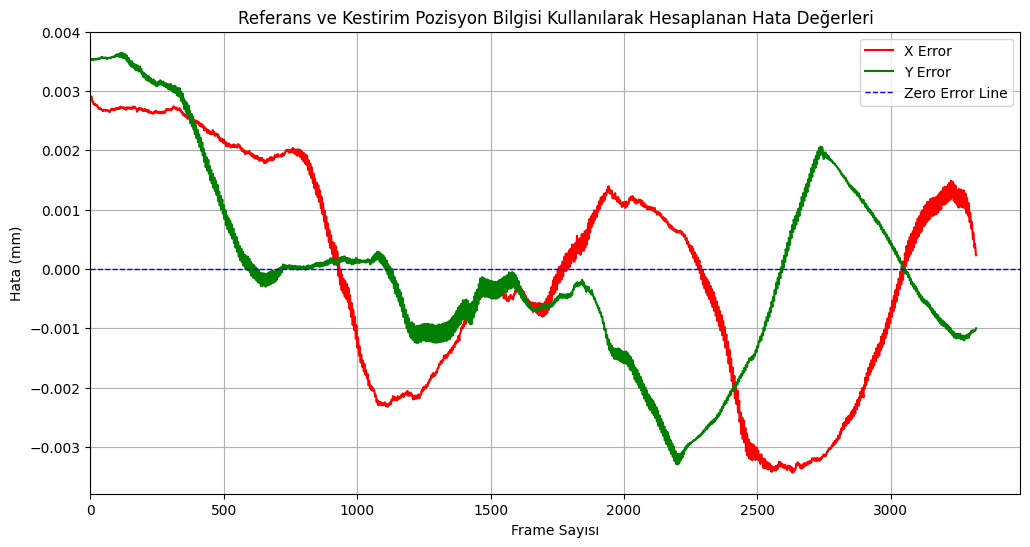

In [68]:

# Hataları X ve Y için ayrı ayrı hesapla
error_x = mtx1[:, 0] - mtx2[:, 0]
error_y = mtx1[:, 1] - mtx2[:, 1]

# X ve Y hataları için istatistiksel değerleri hesapla ve yazdır
for coord, errors in zip(['X', 'Y'], [error_x, error_y]):
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    max_error = np.max(errors)
    min_error = np.min(errors)

    print(f"{coord} Hatası - Ortalama: {mean_error:.4f}, Standart Sapma: {std_error:.4f}, Maksimum: {max_error:.4f}, Minimum: {min_error:.4f}")
    print(f"{coord} Hatası - MSE: {mse:.4f}, RMSE: {rmse:.4f}\n")

# Hata değerlerini çiz
plt.figure(figsize=(12, 6))
frame = np.arange(len(error_x))  # Frame sayısını oluştur
plt.plot(frame, error_x, label='X Error', color='red', linestyle='-', markersize=5)
plt.plot(frame, error_y, label='Y Error', color='green', linestyle='-', markersize=5)
plt.axhline(0, color='blue', linestyle='--', label='Zero Error Line', linewidth=1)  # Sıfır hatası çizgisi

# Y-ekseni sınırlarını ayarla
plt.xlim(left=0)  # X-ekseni sınırlarını ayarla

plt.title('Referans ve Kestirim Pozisyon Bilgisi Kullanılarak Hesaplanan Hata Değerleri')
plt.xlabel('Frame Sayısı')
plt.ylabel('Hata (mm)')
plt.legend()
plt.grid(True)
plt.show()